# Article recommending system introduction:
Article recommending system is a system that makes use of natural language processing and unsupervised k-nearest neighbour to recommend k most relevant articles by papers' title and abstract. It does the task by vectorizing the provided paper's text and using knn to match the "closest" to the provided paper in the database. Besides, the system provides a filter function that accurates to the month to filter out the paper earlier than the specified year and month.

# Insight Deriving:
Inside the COVID-19 Open Research Dataset (CORD-19), there are over 400,000 scholarly articles, including over 150,000 with full text, about COVID-19, SARS-CoV-2, and related coronaviruses. Although the dataset has abundant data, it is very difficult to find the ones that we are interested in without a tool. 

The system using natural language processing and machine learning to helps the users to find relevant papers of a provided paper among all papers in the database by simply providing the title and the abstract of the provided paper. The system provides scientists, healthcare professionals and other users to find ones' interested article efficiently and conveniently. Using the system during the research of Covid-19 can speed up the study process to a great extent which is a help to tackle the current outbreak based on a machine learning model. 

# Install and import necessary packages

In [1]:
!pip install tqdm_notebook > /dev/null 2>&1

In [2]:
!pip install scispacy > /dev/null 2>&1

In [3]:
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_lg-0.4.0.tar.gz > /dev/null 2>&1

In [4]:
#Import Libraries

import csv
import random
import numpy as np
import pandas as pd
import html
import re

# Plotting
import matplotlib.pyplot as plt

import scispacy
import spacy
import en_core_sci_lg

%matplotlib inline

In [5]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  from tqdm.notebook import tqdm_notebook as tqdm
  tqdm.pandas()
  drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


**Please modify the following path to run in your local machine**

In [6]:
base_path = "/content/drive/MyDrive/Colab Notebooks/data/"

# Data cleaning

In [7]:
df = pd.read_csv(base_path+"metadata.csv", low_memory=False)
df.info(verbose=True)
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497906 entries, 0 to 497905
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   cord_uid          497906 non-null  object 
 1   sha               172105 non-null  object 
 2   source_x          497906 non-null  object 
 3   title             497674 non-null  object 
 4   doi               281753 non-null  object 
 5   pmcid             182522 non-null  object 
 6   pubmed_id         241936 non-null  object 
 7   license           497906 non-null  object 
 8   abstract          363064 non-null  object 
 9   publish_time      497687 non-null  object 
 10  authors           484020 non-null  object 
 11  journal           464755 non-null  object 
 12  mag_id            0 non-null       float64
 13  who_covidence_id  197568 non-null  object 
 14  arxiv_id          6687 non-null    object 
 15  pdf_json_files    172105 non-null  object 
 16  pmc_json_files    13

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN


In [8]:
# load the meta data from the CSV file and extract out fields that will be useful to our application

df = df[['title','abstract','publish_time', 'cord_uid', 'who_covidence_id']]
df = df.drop_duplicates(subset='abstract', keep="first")
df=df.dropna()
df["abstract"] = df["abstract"].str.lower()
df["title"] = df["title"].str.lower()

Only choose the articles related to COVID-19 for this project. I assume that papers with a who_covidence_id are related to COVID-19.

In [9]:
df.shape

(107785, 5)

In [10]:
df.head()

,title,abstract,publish_time,cord_uid,who_covidence_id
131452,simple discrete-time self-exciting models can ...,hawkes processes are a form of self-exciting p...,2020,gupghjy5,#20221077
131488,inhibitors for novel coronavirus protease iden...,the rapid outbreak of the novel severe acute r...,2020,bbumotlt,#7330
131531,induction of “cytokine storm” in patients infe...,coronaviruses are an extensive family of virus...,2020,fmfp5a4x,#606820
131551,modelling testing and response strategies for ...,backgroundremote australian aboriginal and tor...,2020,c28dddod,#20208819
131557,cities and immigrants: the local in anti‐immig...,few americans would guess that from 2014 to 20...,2020,3htlc0qi,#143703975


We use scispaCy for preprocessing, which is a Python package containing spaCy models for processing scientific text.

In [11]:
nlp = en_core_sci_lg.load(disable=["parser", "ner"])
nlp.max_length = 2000000

In [12]:
def clean_text(sentence):
  sentence = html.unescape(sentence) # replaces HTML charachter codes with ASCII equivalent
  sentence = re.sub(r"http\S+", "", sentence) # removes URL links
  wordsList = []
  for word in nlp(sentence):
    if not (word.is_stop or word.is_space or word.like_num or word.is_punct or len(word)<2):
      wordsList.append(word.lemma_)
  return " ".join(wordsList)

Add customize stop words

In [13]:
customize_stop_words = [
    'doi', 'preprint', 'copyright', 'https', 'author', 'figure', 'table',
    'rights', 'reserved', 'permission', 'use', 'biorxiv', 'medrxiv', 
    'license', 'fig', 'fig.', 'al.', 'PMC', 'CZI', 
    'br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', \
    "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', \
    'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", \
    'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', \
    'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', \
    'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', \
    'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
    'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', \
    'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', \
    'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', \
    'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'only', \
    'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", \
    'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", \
    'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', \
    "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', \
    "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", \
    'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"
]
for word in customize_stop_words:
    nlp.vocab[word].is_stop = True

Apply the nlp model to title and abstract columns.

In [14]:
def clean_df(data):
  data['cleaned_title'] = data['title'].progress_apply(clean_text)
  data['cleaned_abstract'] = data['abstract'].progress_apply(clean_text)
clean_df(df)

Convert the publish time to datetime object, and categorize the time into year and month separately.

In [15]:
df['publish_time'] = pd.to_datetime(df['publish_time'])
def categorize_time(data):
  data['publish_year'] = data['publish_time'].dt.year
  data['publish_month'] = data['publish_time'].dt.month
categorize_time(df)

Save the preprocessed dataframe

In [16]:
df.to_csv(base_path + "preproced_metadata.csv")

# Data visualization

In [17]:
proced_df = pd.read_csv(base_path + "preproced_metadata.csv", low_memory=False)

In [18]:
proced_df = proced_df.dropna()

In [19]:
proced_df.head()

,Unnamed: 0,title,abstract,publish_time,cord_uid,who_covidence_id,cleaned_title,cleaned_abstract,publish_year,publish_month
0,131452,simple discrete-time self-exciting models can ...,hawkes processes are a form of self-exciting p...,2020-01-01,gupghjy5,#20221077,simple discrete-time self-exciting model descr...,hawke process form self-exciting process numer...,2020,1
1,131488,inhibitors for novel coronavirus protease iden...,the rapid outbreak of the novel severe acute r...,2020-01-01,bbumotlt,#7330,inhibitor novel coronavirus protease identify ...,rapid outbreak novel severe acute respiratory ...,2020,1
2,131531,induction of “cytokine storm” in patients infe...,coronaviruses are an extensive family of virus...,2020-01-01,fmfp5a4x,#606820,induction cytokine storm patient infect sars-c...,coronaviruse extensive family virus produce di...,2020,1
3,131551,modelling testing and response strategies for ...,backgroundremote australian aboriginal and tor...,2020-01-01,c28dddod,#20208819,model testing response strategy covid-19 outbr...,backgroundremote australian aboriginal torre s...,2020,1
4,131557,cities and immigrants: the local in anti‐immig...,few americans would guess that from 2014 to 20...,2020-01-01,3htlc0qi,#143703975,city immigrant local anti‐immigration federal ...,american guess baton rouge louisiana cincinnat...,2020,1


## publish year distribution

As we can see, most of the articles articles published in 2020, so filtering the articles by year would not be very helpful. Therefore, we can add month to the filtering condition to help user filter the articles according to the publish time more accurately. 

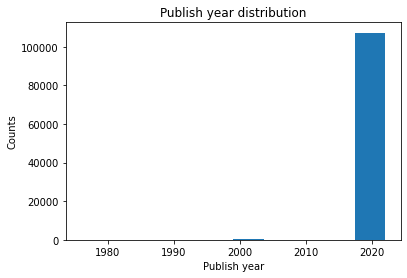

In [20]:
proced_df['publish_year'].plot.hist()
plt.xlabel('Publish year')  
plt.ylabel('Counts')
plt.title('Publish year distribution')
plt.show()

## Plot word frequency for abstract

In [21]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [22]:
def get_word_freq(data, top_N=20):
  preproced_data = data.str.cat(sep=' ')
  words = nltk.tokenize.word_tokenize(preproced_data)
  words_selected = [i for i in words if len(i) > 2]
  words_dist = nltk.FreqDist(words_selected)
  words_freq = pd.DataFrame(words_dist.most_common(top_N),
                      columns=['Word', 'Frequency'])
  return words_freq, words_dist

In [23]:
from wordcloud import WordCloud
def draw_word_cloud(word_dist, title):
  wordcloud = WordCloud(width=800, height=500, max_font_size=110).generate_from_frequencies(word_dist)
  plt.figure(figsize=(10, 10))
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.title("Title words cloud")
  plt.axis('off')
  plt.show()

In [24]:
abstract_words_freq, abstract_words_dist = get_word_freq(proced_df['cleaned_abstract'], top_N=20)

In [25]:
abstract_words_freq

,Word,Frequency
0,covid-19,244492
1,patient,171172
2,study,89968
3,pandemic,85986
4,disease,83140
5,health,68504
6,result,68415
7,sars-cov-2,68145
8,coronavirus,59760
9,infection,56866


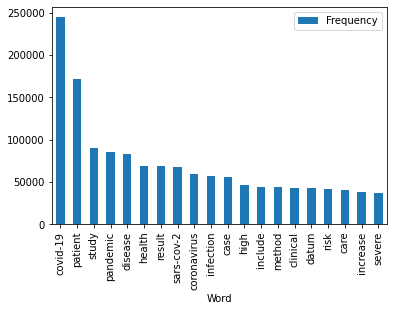

In [26]:
abstract_words_freq.plot(x='Word', y='Frequency', kind='bar')

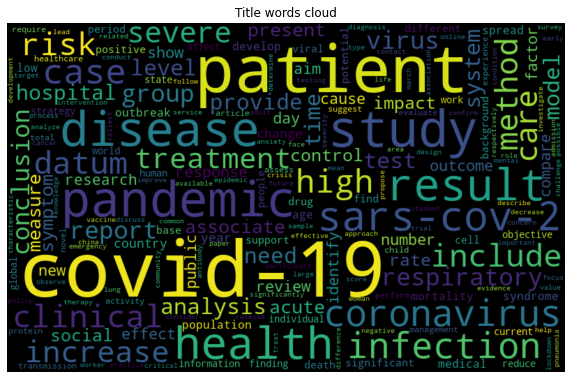

In [27]:
draw_word_cloud(abstract_words_dist, "Abstract word cloud")

## Plot word frequency for title

In [28]:
title_words_freq, title_words_dist = get_word_freq(proced_df['cleaned_title'], top_N=20)

In [29]:
title_words_freq

,Word,Frequency
0,covid-19,63201
1,pandemic,17908
2,patient,14312
3,sars-cov-2,11874
4,coronavirus,10107
5,disease,8701
6,study,8464
7,infection,6349
8,health,6321
9,impact,5608


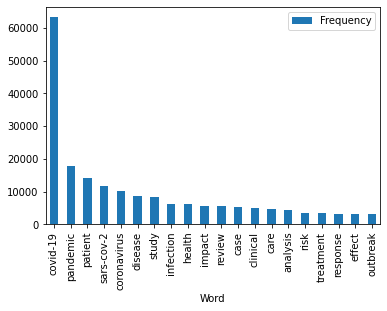

In [30]:
title_words_freq.plot(x='Word', y='Frequency', kind='bar')

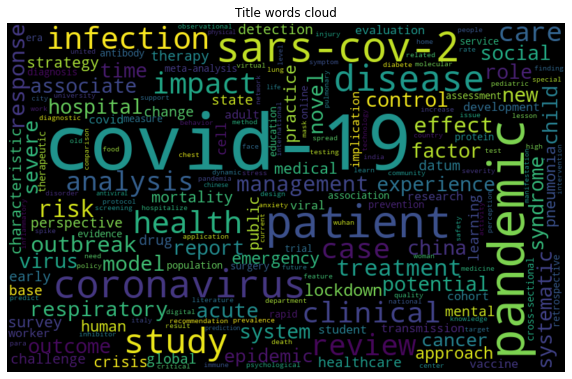

In [31]:
draw_word_cloud(title_words_dist, "Title word cloud")

## Data visualization summary

By visualizing the data, I find out that words directly related Covid-19 appears very frequently in both title and abstract. Therefore, if we want to make distictions and calculate meaningful distances between articles, we have to ignore words that appears most frequent in title and abstract

# Model selection and fitting to the data

Since there are no easy ways to evaluate an unsupervised model, I only choose a small subset data as test set to test the functionality of the model.

In [32]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(proced_df, test_size=50, random_state=42)

In [33]:
print(f"Training set shape: {train_df.shape}")
print(f"Testing set shape: {test_df.shape}")

Training set shape: (107717, 10)
Testing set shape: (50, 10)


In [34]:
from sklearn.base import TransformerMixin
from sklearn.neighbors import NearestNeighbors
class NNWrapper(TransformerMixin):
  '''
  Nearest Neighbour wrapper for pipeline
  '''
  def __init__(self, knn_args):
    self.knn = NearestNeighbors(**knn_args)

  def fit(self, X, y=None):
    self.knn.fit(X)

  def predict(self, X, **predict_params):
    return self.knn.kneighbors(X, predict_params['n_neighbors'], predict_params['return_distance'])

I use a simple pipeline to train my model by following steps below:


1.   I use a column transformer to process title and abstract independently and I choose TFIDF as my vectorizer since it usually performs better than word frequency in my experience.
2.   Then the preprocessed data is fed into the knn model for training.



In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


def train(train_df, title_args, abstract_args, knn_args):
  preprocess = ColumnTransformer([
                                  ('title', TfidfVectorizer(**title_args), 'cleaned_title'),
                                  ('abstract', TfidfVectorizer(**abstract_args), 'cleaned_abstract')
                                  ], remainder = 'drop', n_jobs=-1)
          
  pipe = Pipeline([
                  ('preprocess', preprocess),
                  ('model', NNWrapper(knn_args))
          ],
          verbose=True)
  pipe.fit(train_df)
  return pipe

In the cell below, I specify the arguments for the models in the pipeline.
In particular, note that by setting min_df and max_df, I only take the words that appear more than 10% and less than 90%. By setting min_df, we don't consider the extremely rare words, and the reason for setting max_df has been stated in data visualization part.

In [36]:
MAX_FEATURES_TITLE = 1000
MAX_FEATURES_ABSTRACT = 10000
title_args = {'min_df': 0.1,  'max_df':0.9,'max_features': MAX_FEATURES_TITLE, 'ngram_range': (1, 3)}
abstract_args = {'min_df': 0.1,  'max_df':0.9, 'max_features': MAX_FEATURES_ABSTRACT, 'ngram_range': (1, 4)}
knn_args = {'n_neighbors': 3, 'n_jobs': -1}
model = train(train_df, title_args, abstract_args, knn_args)

[Pipeline] ........ (step 1 of 2) Processing preprocess, total= 7.5min
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s


In [37]:
def get_kneighbors(model, X, k=3, return_distance=True):
  return model.predict(X, n_neighbors=k, return_distance=return_distance)

In [38]:
def recommand(model, paper, database, no_earlier=None, k=3):
  '''
  The function takes an input of a single paper and recommands the k most relevant papers in the database.
  no_earlier(str): is a filter to discard the papers strictly earlier than the argument. It should be in the format of year-month(e.g. '2020-08')
  '''
  no_earlier_dt = pd.to_datetime(no_earlier)
  dists, nn = get_kneighbors(model, paper, k)
  recommand_papers = database.iloc[nn[0], :].copy()
  recommand_papers['distance'] = dists[0]
  if no_earlier:
    return recommand_papers[recommand_papers['publish_time'] > no_earlier]
  return recommand_papers

## Test the model

Test the model by finding the k=5 most relevant papers of another paper.

In [39]:
test_paper = test_df.iloc[[1]]

In [40]:
test_paper

,Unnamed: 0,title,abstract,publish_time,cord_uid,who_covidence_id,cleaned_title,cleaned_abstract,publish_year,publish_month
100244,339499,covid-19 and the increasing need for sex-disag...,in countries most impacted by coronavirus dise...,2020-01-01,a4g9pjxw,#827772,covid-19 increase need sex-disaggregated morta...,country impact coronavirus disease covid-19 it...,2020,1


In [41]:
recommand_papers = recommand(model, test_paper, train_df, k=5)

In [42]:
recommand_papers

,Unnamed: 0,title,abstract,publish_time,cord_uid,who_covidence_id,cleaned_title,cleaned_abstract,publish_year,publish_month,distance
100935,340835,call for proper documentation of covid-19 deat...,introduction: a pandemic is an epidemic at a g...,2021-01-01,y4mj85uc,#1066155,proper documentation covid-19 death poor resou...,introduction pandemic epidemic global scale wo...,2021,1,0.802243
100936,340836,call for proper documentation of covid-19 deat...,introduction: a pandemic is an epidemic at a g...,2020-01-01,y4mj85uc,#690824,proper documentation covid-19 death poor resou...,introduction pandemic epidemic global scale wo...,2020,1,0.802243
8376,165426,defunciones por covid-19: no están todas las q...,the death counts from covid-19 have generated ...,2020-01-01,wp2j72j6,#663219,defuncione por covid-19 están todas las que so...,death count covid-19 generate public controver...,2020,1,0.827575
49374,242395,[thoughts and suggestions on analysis of death...,it is an essential task to discuss the death c...,2020-01-01,263pvaqn,#324713,thought suggestion analysis death case report ...,essential task discuss death case clinician em...,2020,1,0.849359
18417,184202,"covid-19 situation report, n.23 (31 august 2020)",following an outbreak of a novel coronavirus (...,2020-01-01,8tw740co,#743768,covid-19 situation report n.23 august,follow outbreak novel coronavirus covid-19 wuh...,2020,1,0.852174


Filter out the paper earlier than 2020-09

In [43]:
recommand_papers_filtered = recommand(model, test_paper, train_df, k=5, no_earlier='2020-09')

In [44]:
recommand_papers_filtered

,Unnamed: 0,title,abstract,publish_time,cord_uid,who_covidence_id,cleaned_title,cleaned_abstract,publish_year,publish_month,distance
100935,340835,call for proper documentation of covid-19 deat...,introduction: a pandemic is an epidemic at a g...,2021-01-01,y4mj85uc,#1066155,proper documentation covid-19 death poor resou...,introduction pandemic epidemic global scale wo...,2021,1,0.802243


Plot the distance betwenn the provided paper and relevant papers. Using the paper titles as the x-label would be too long, so I choose to use cord_id instead.

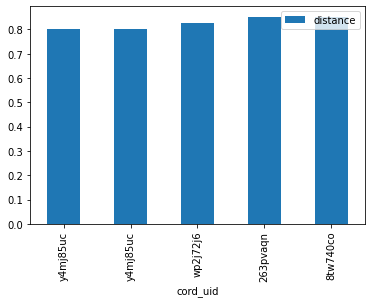

In [46]:
recommand_papers.plot(x='cord_uid', y='distance', kind='bar')

Function to retrieve all recommendations of provided papers at once.

In [47]:
def retrieve_all_recom(model, papers, database, no_earlier=None, k=2):
  '''
  Providing a dataframe of papers, the function returns a dataframe the k most relevant papers
  for each provided paper. The dataframe also adds the original provided paper's title on a new column
  for better reference.
  '''
  paper_storer = []

  for i in range(0, papers.shape[0]):
    orig_paper = papers.iloc[[i]]
    recom_papers = recommand(model, orig_paper, database, k=k)
    recom_papers['original_paper_title'] = orig_paper['title'].values[0]
    paper_storer.append(recom_papers)
  all_recommand_papers = pd.concat(paper_storer, axis=0)
  if no_earlier:
    return all_recommand_papers[all_recommand_papers['publish_time'] > no_earlier]
  return all_recommand_papers

In [48]:
all_recommand_papers = retrieve_all_recom(model, test_df, train_df, k=2)

In [49]:
all_recommand_papers

,Unnamed: 0,title,abstract,publish_time,cord_uid,who_covidence_id,cleaned_title,cleaned_abstract,publish_year,publish_month,distance,original_paper_title
34311,213930,lessons from covid-19 clinical trials and the ...,since the outbreak of the coronavirus disease ...,2020-01-01,wd8gng2z,#618911,lesson covid-19 clinical trial concept nationa...,outbreak coronavirus disease covid-19 interven...,2020,1,0.862955,covid-19 and telenutrition: remote consultatio...
1312,152159,a pilot of a virtual objective structured clin...,introduction: the outbreak of covid-19 necessi...,2020-01-01,w6zuhxvb,#960832,pilot virtual objective structured clinical ex...,introduction outbreak covid-19 necessitate onl...,2020,1,0.882319,covid-19 and telenutrition: remote consultatio...
100936,340836,call for proper documentation of covid-19 deat...,introduction: a pandemic is an epidemic at a g...,2020-01-01,y4mj85uc,#690824,proper documentation covid-19 death poor resou...,introduction pandemic epidemic global scale wo...,2020,1,0.802243,covid-19 and the increasing need for sex-disag...
100935,340835,call for proper documentation of covid-19 deat...,introduction: a pandemic is an epidemic at a g...,2021-01-01,y4mj85uc,#1066155,proper documentation covid-19 death poor resou...,introduction pandemic epidemic global scale wo...,2021,1,0.802243,covid-19 and the increasing need for sex-disag...
63179,268984,teaching epidemiology online (pandemic edition),in response to the threat posed by the covid-1...,2020-01-01,c5rnput8,#990554,teach epidemiology online pandemic edition,response threat pose covid-19 pandemic univers...,2020,1,0.935594,some reflections on ethical care dilemmas in a...
...,...,...,...,...,...,...,...,...,...,...,...,...
55734,254648,the role of perceived mental stress in the hea...,background and aim: mental stress has always i...,2020-01-01,qf9a2gg3,#831287,role perceive mental stress health suspect cas...,background aim mental stress influence behavio...,2020,1,0.835996,psychological distress and adaptation to the c...
42796,230066,hcov- and sars-cov-2 cross-reactive t cells in...,the inability of patients with cvid to mount s...,2020-01-01,2bzcsyq5,#1021890,hcov- sars-cov-2 cross-reactive cell cvid patient,inability patient cvid mount specific antibody...,2020,1,0.621758,sars-cov-2 vaccination for patients with infla...
68612,279309,"interferon gamma, tgf-ß1 and rantes expression...",upper respiratory tract is the primary site of...,2020-01-01,l4rh42ed,#733901,interferon gamma tgf-ß1 rante expression upper...,upper respiratory tract primary site sars-cov-...,2020,1,0.628773,sars-cov-2 vaccination for patients with infla...
53658,250661,stochastic filtering based transmissibility es...,"in this study, the transmissibility estimation...",2021-01-01,tnchxspv,#1080658,stochastic filtering based transmissibility es...,study transmissibility estimation novel corona...,2021,1,0.645808,new investigation of bats-hosts-reservoir-peop...
